In [1]:
%load_ext autoreload
%autoreload 2
# load dataset 
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_utils
import RS_models

/mnt/hdd/eric/.conda/envs/a.samrs/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [1]:
#---
import os
import shutil
from collections import defaultdict
import numpy as np 
from glob import glob
import os
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
#---
import torch.nn as nn 
import datetime
import logging
import easydict
#---
from lightning.fabric import Fabric
import lightning as L
import segmentation_models_pytorch as smp

#-- data

img_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/SAM_ship_mask/HRSC2016/AllImages"
mask_name_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/SAM_ship_mask/all_names_saved_h.npy"
mask_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/SAM_ship_mask/all_masks_saved_h.npy"


/mnt/hdd/eric/.conda/envs/a.samrs/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
mask_names = np.load(mask_name_path,allow_pickle=True)

In [6]:
mask_names

array(['100000001', '100000002', '100000003', ..., '100001678',
       '100001679', '100001680'], dtype=object)

In [7]:
sorted(os.listdir(img_path))

['100000001.bmp',
 '100000002.bmp',
 '100000003.bmp',
 '100000004.bmp',
 '100000005.bmp',
 '100000006.bmp',
 '100000007.bmp',
 '100000008.bmp',
 '100000009.bmp',
 '100000010.bmp',
 '100000011.bmp',
 '100000012.bmp',
 '100000013.bmp',
 '100000014.bmp',
 '100000015.bmp',
 '100000016.bmp',
 '100000017.bmp',
 '100000018.bmp',
 '100000019.bmp',
 '100000020.bmp',
 '100000021.bmp',
 '100000022.bmp',
 '100000023.bmp',
 '100000024.bmp',
 '100000025.bmp',
 '100000026.bmp',
 '100000027.bmp',
 '100000028.bmp',
 '100000029.bmp',
 '100000030.bmp',
 '100000031.bmp',
 '100000032.bmp',
 '100000033.bmp',
 '100000034.bmp',
 '100000035.bmp',
 '100000036.bmp',
 '100000037.bmp',
 '100000038.bmp',
 '100000039.bmp',
 '100000040.bmp',
 '100000041.bmp',
 '100000042.bmp',
 '100000043.bmp',
 '100000044.bmp',
 '100000045.bmp',
 '100000046.bmp',
 '100000047.bmp',
 '100000048.bmp',
 '100000049.bmp',
 '100000050.bmp',
 '100000051.bmp',
 '100000052.bmp',
 '100000053.bmp',
 '100000054.bmp',
 '100000055.bmp',
 '10000005

In [ ]:

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/Segmentation_1/03.data_list/512_ships.npy")


selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#---------------------------------
#-- args operation
EXEC_VER = 1 # zero means test 
DDP = False
TASK = "Seg"

#-- args data 
CROP_SIZE = 256
DATA_PATH_IMG = selected_paths_img
DATA_PATH_LABEL = selected_paths_mask
#-- args modeling 
MODEL_NAME = "Unet++"
MODEL_IN_CHANNEL = 3   # image channel  
MODEL_OUT_CHANNEL = 3  # mask channel and category 
CRITERION = "CE"
BATCH_SIZE = 8 # 4
LEARNING_RATE = 1e-3 #1e-5
#-- args train
DEVICE = "cuda:0"
DEVICES = [0,1,2,3]
RESUME = False
SAVE_EPOCH = 20
EPOCHS = 140
DATA_SHUFFLE = True
#-- args category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)
    }
#---------------------------------

#--- logger
log_path = f'/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Tasks/Segmentation_2/DATA_Ship_Seg/01.log/ver_{EXEC_VER}_%Y-%m-%d_%H-%M-%S.log'
logger = RS_utils.log_creator(log_path)

In [45]:
#-- dataset
train_dataset = RS_dataset.Seg_RS_dataset_edge_v5(img_dir = DATA_PATH_IMG, 
                                                  mask_dir = DATA_PATH_LABEL, 
                                                  image_resize = None, 
                                                  crop_size = CROP_SIZE, 
                                                  phase = "train",
                                                  palette=ISAID_PALETTE_SHIP,
                                                  edge_return=False,
                                                  mask_onehot=False)
image, label = train_dataset.__getitem__(10)

In [46]:
label.shape

torch.Size([256, 256])

In [47]:
label.shape

torch.Size([256, 256])

In [48]:
label = label.unsqueeze(0)
label.shape

torch.Size([1, 256, 256])

2024-04-09 14:59:22,757 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


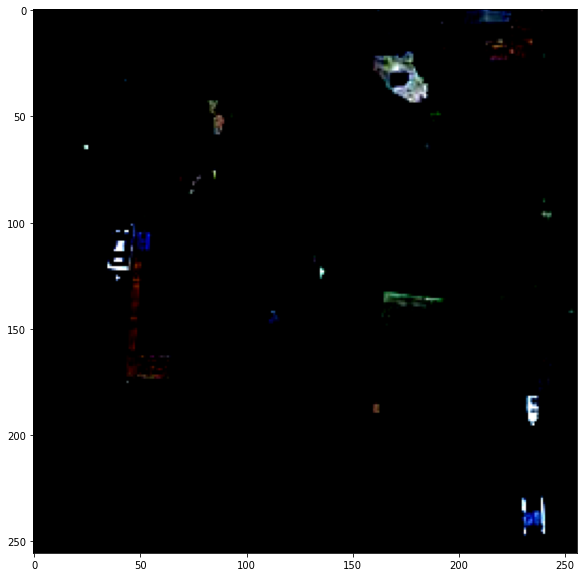

In [49]:
RS_utils.torch_display(image,batch=False)

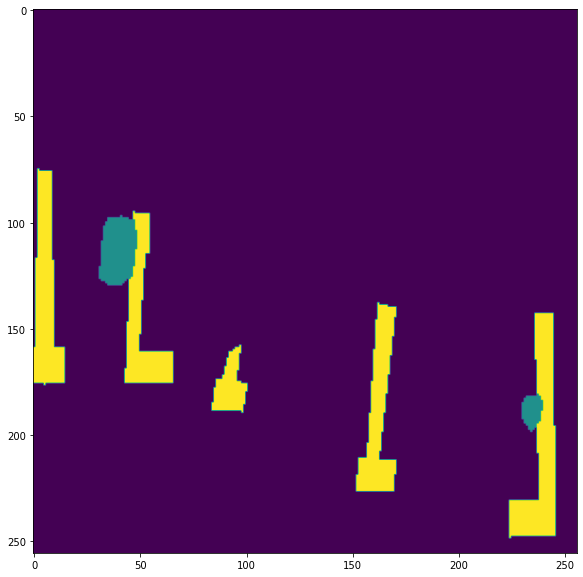

In [50]:
RS_utils.torch_display(label,batch=False)

In [8]:
model = model.eval()
pred = model(label)

In [9]:
pred.shape

torch.Size([1, 256, 256])

In [10]:
pred = pred.detach().cpu()

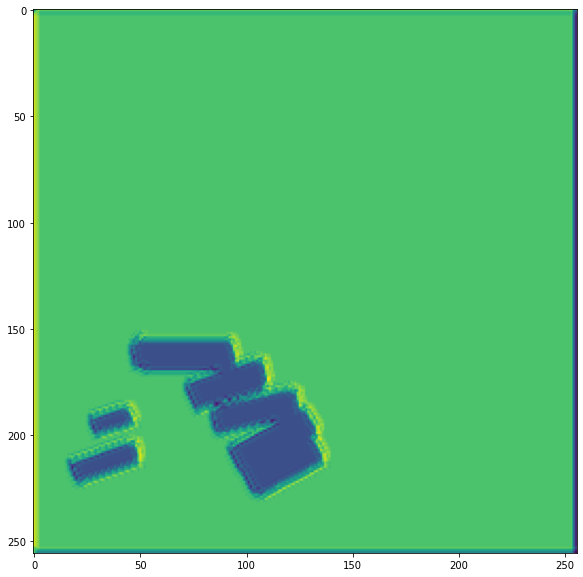

In [11]:
RS_utils.torch_display(pred,batch=False)

In [12]:
# sigmoid 
pred_ = torch.sigmoid(pred)

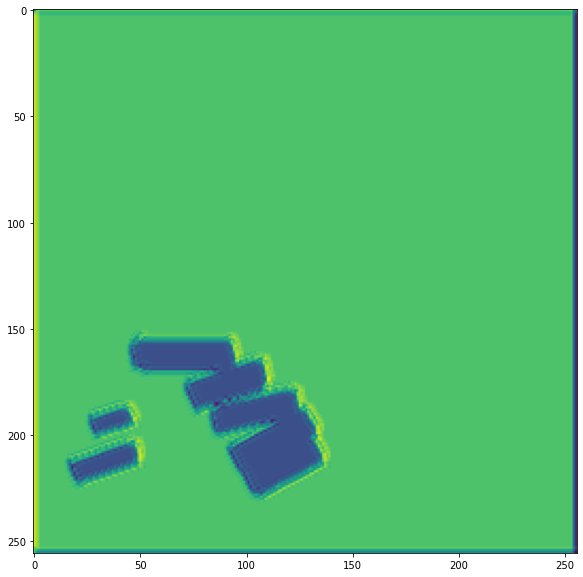

In [13]:
RS_utils.torch_display(pred_,batch=False)

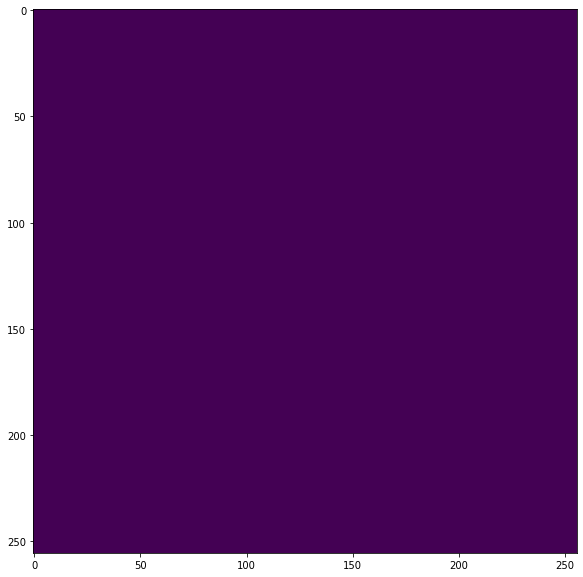

In [24]:
part = pred.clone()
#map = part > 1
map = torch.sigmoid(part)
map = map > 0.1
#print(torch.mean(map))
RS_utils.torch_display(map,batch=False)

In [28]:
pred > 0.01

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True, False]]])